<a href="https://colab.research.google.com/github/sutharimanikanta/Golab/blob/main/submarine(reinforcement%20learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

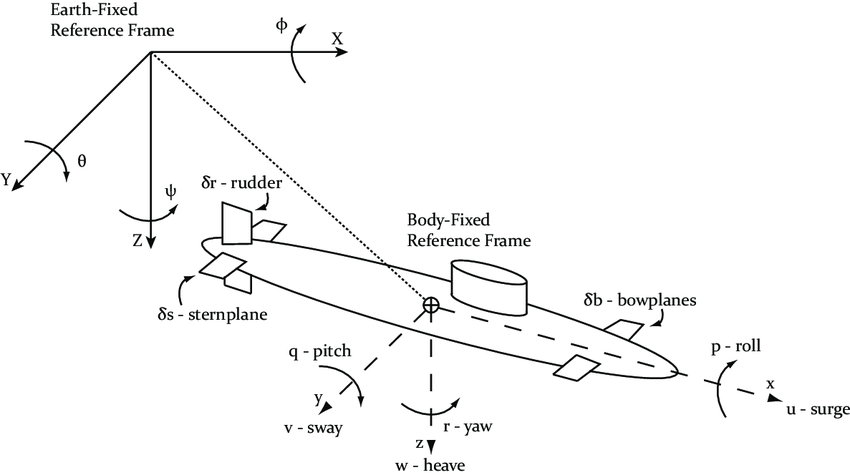

In [ ]:
import numpy as np
import csv


def C(x):
    return np.cos(x)


def S(x):
    return np.sin(x)


def earth_to_body_frame(ii, jj, kk):
    # C^b_n
    R = [[C(kk) * C(jj), C(kk) * S(jj) * S(ii) - S(kk) * C(ii), C(kk) * S(jj) * C(ii) + S(kk) * S(ii)],
         [S(kk) * C(jj), S(kk) * S(jj) * S(ii) + C(kk) * C(ii), S(kk) * S(jj) * C(ii) - C(kk) * S(ii)],
         [-S(jj), C(jj) * S(ii), C(jj) * C(ii)]]
    return np.array(R)


def body_to_earth_frame(ii, jj, kk):
    # C^n_b
    return np.transpose(earth_to_body_frame(ii, jj, kk))


class PhysicsSim():
    def __init__(self, init_pose=None, init_velocities=None, init_angle_velocities=None, runtime=5.):
        self.init_pose = init_pose
        self.init_velocities = init_velocities
        self.init_angle_velocities = init_angle_velocities
        self.runtime = runtime

        self.gravity = -9.81  # m/s
        self.rho = 1.2
        self.mass = 0.958  # 300 g
        self.dt = 1 / 50.0  # Timestep
        self.C_d = 0.3
        self.l_to_rotor = 0.4
        self.propeller_size = 0.1
        width, length, height = .51, .51, .235
        self.dims = np.array([width, length, height])  # x, y, z dimensions of quadcopter
        self.areas = np.array([length * height, width * height, width * length])
        I_x = 1 / 12. * self.mass * (height**2 + width**2)
        I_y = 1 / 12. * self.mass * (height**2 + length**2)  # 0.0112 was a measured value
        I_z = 1 / 12. * self.mass * (width**2 + length**2)
        self.moments_of_inertia = np.array([I_x, I_y, I_z])  # moments of inertia

        env_bounds = 300.0  # 300 m / 300 m / 300 m
        self.lower_bounds = np.array([-env_bounds / 2, -env_bounds / 2, 0])
        self.upper_bounds = np.array([env_bounds / 2, env_bounds / 2, env_bounds])

        self.reset()

    def reset(self):
        self.time = 0.0
        self.pose = np.array([0.0, 0.0, 10.0, 0.0, 0.0, 0.0]) if self.init_pose is None else np.copy(self.init_pose)
        self.v = np.array([0.0, 0.0, 0.0]) if self.init_velocities is None else np.copy(self.init_velocities)
        self.angular_v = np.array([0.0, 0.0, 0.0]) if self.init_angle_velocities is None else np.copy(self.init_angle_velocities)
        self.linear_accel = np.array([0.0, 0.0, 0.0])
        self.angular_accels = np.array([0.0, 0.0, 0.0])
        self.prop_wind_speed = np.array([0., 0., 0., 0.])
        self.done = False

    def find_body_velocity(self):
        body_velocity = np.matmul(earth_to_body_frame(*list(self.pose[3:])), self.v)
        return body_velocity

    def get_linear_drag(self):
        linear_drag = 0.5 * self.rho * self.find_body_velocity()**2 * self.areas * self.C_d
        return linear_drag

    def get_linear_forces(self, thrusts):
        # Gravity
        gravity_force = self.mass * self.gravity * np.array([0, 0, 1])
        # Thrust
        thrust_body_force = np.array([0, 0, sum(thrusts)])
        # Drag
        drag_body_force = -self.get_linear_drag()
        body_forces = thrust_body_force + drag_body_force

        linear_forces = np.matmul(body_to_earth_frame(*list(self.pose[3:])), body_forces)
        linear_forces += gravity_force
        return linear_forces

    def get_moments(self, thrusts):
        thrust_moment = np.array([(thrusts[3] - thrusts[2]) * self.l_to_rotor,
                            (thrusts[1] - thrusts[0]) * self.l_to_rotor,
                            0])# (thrusts[2] + thrusts[3] - thrusts[0] - thrusts[1]) * self.T_q])  # Moment from thrust

        drag_moment =  self.C_d * 0.5 * self.rho * self.angular_v * np.absolute(self.angular_v) * self.areas * self.dims * self.dims
        moments = thrust_moment - drag_moment # + motor_inertia_moment
        return moments

    def calc_prop_wind_speed(self):
        body_velocity = self.find_body_velocity()
        phi_dot, theta_dot = self.angular_v[0], self.angular_v[1]
        s_0 = np.array([0., 0., theta_dot * self.l_to_rotor])
        s_1 = -s_0
        s_2 = np.array([0., 0., phi_dot * self.l_to_rotor])
        s_3 = -s_2
        speeds = [s_0, s_1, s_2, s_3]
        for num in range(4):
            perpendicular_speed = speeds[num] + body_velocity
            self.prop_wind_speed[num] = perpendicular_speed[2]

    def get_propeler_thrust(self, rotor_speeds):
        '''calculates net thrust (thrust - drag) based on velocity
        of propeller and incoming power'''
        thrusts = []
        for prop_number in range(4):
            V = self.prop_wind_speed[prop_number]
            D = self.propeller_size
            n = rotor_speeds[prop_number]
            J = V / n * D
            # From http://m-selig.ae.illinois.edu/pubs/BrandtSelig-2011-AIAA-2011-1255-LRN-Propellers.pdf
            C_T = max(.12 - .07*max(0, J)-.1*max(0, J)**2, 0)
            thrusts.append(C_T * self.rho * n**2 * D**4)
        return thrusts

    def next_timestep(self, rotor_speeds):
        self.calc_prop_wind_speed()
        thrusts = self.get_propeler_thrust(rotor_speeds)
        self.linear_accel = self.get_linear_forces(thrusts) / self.mass

        position = self.pose[:3] + self.v * self.dt + 0.5 * self.linear_accel * self.dt**2
        self.v += self.linear_accel * self.dt

        moments = self.get_moments(thrusts)

        self.angular_accels = moments / self.moments_of_inertia
        angles = self.pose[3:] + self.angular_v * self.dt + 0.5 * self.angular_accels * self.angular_accels * self.dt**2
        angles = (angles + 2 * np.pi) % (2 * np.pi)
        self.angular_v = self.angular_v + self.angular_accels * self.dt

        new_positions = []
        for ii in range(3):
            if position[ii] <= self.lower_bounds[ii]:
                new_positions.append(self.lower_bounds[ii])
                self.done = True
            elif position[ii] > self.upper_bounds[ii]:
                new_positions.append(self.upper_bounds[ii])
                self.done = True
            else:
                new_positions.append(position[ii])

        self.pose = np.array(new_positions + list(angles))
        self.time += self.dt
        if self.time > self.runtime:
            self.done = True
        return self.done

In [ ]:
import numpy as np
"""the goal and provides feedback to the agent."""
class Task():
  def __init__(self,init_pose=[0.,0.,0.,0.,0.,0.],init_v=None,init_angle_v=None,runtime=5.,traget_pos=None):
    self.sim=PhysicsSim(init_pose,init_v,init_angle_v,runtime)
    self.action_repeat=3
    self.state_size=self.action_repeat*6
    self.action_low=0
    self.action_size=4
    self.action_high=900
    # Goal
    self.target_pos if target_pos is not None else np.array([0.,0.,10.])
  def get_reward(self):
        """Uses current state of the simulation to return reward."""

        # Initial reward based on depth (Z position)
        reward = 0.3 * self.sim.pose[2]  # Assuming positive Z direction is downwards

        # Penalty for excessive lateral movement (X and Y velocities)
        if abs(self.sim.v[0]) > 3 or abs(self.sim.v[1]) > 3:
            reward -= 15

        # Penalty for negative vertical velocity (descending)
        if self.sim.v[2] > 0:
            reward -= 20

        # Reward for positive vertical velocity (ascending)
        elif self.sim.v[2] < 0:
            reward += 50

        # Penalty for excessive rotation
        euler_angles = np.abs(self.sim.pose[3:6]).sum()
        reward -= euler_angles

        # Reward on how close the vertical coordinates are to the target
        if abs(self.sim.pose[2] - self.target_pos[2]) < 3:
            reward += 20
        if abs(self.sim.pose[2] - self.target_pos[2]) < 1:
            reward += 30

        # Additional reward for minimizing lateral and vertical distances to target
        lateral_distance = ((self.sim.pose[0] - self.target_pos[0]) + (self.sim.pose[2] - self.target_pos[2])) / 2
        reward -= lateral_distance
        vertical_distance = (self.sim.pose[1] - self.target_pos[1]) / 2
        if vertical_distance != 0:
            reward += 100 / vertical_distance

        reward = np.clip(reward, -1, 1)
        return reward
  def step(self, rotor_speeds):
      """Uses action to obtain next state, reward, done."""
      reward = 0
      pose_all = []
      for _ in range(self.action_repeat):
          done = self.sim.next_timestep(rotor_speeds) # update the sim pose and velocities
          reward += self.get_reward()
          pose_all.append(self.sim.pose)
      next_state = np.concatenate(pose_all)
      return next_state, reward, done
  def reset(self):
      """Reset the sim to start a new episode."""
      self.sim.reset()
      state = np.concatenate([self.sim.pose] * self.action_repeat)
      return state




In [ ]:
import random

In [ ]:
class ROV_Agent():
    def __init__(self, task, num_thrusters):
        self.task = task
        self.num_thrusters = num_thrusters

    def act(self, depth, pitch, yaw):
        # Generate thrust values for each thruster
        thrust_values = []
        for _ in range(self.num_thrusters):
            # Example: Generate thrust values for propulsive forces or torques
            # Adjust thrust values based on desired movement and ROV dynamics
            # Incorporate parameters such as depth, pitch, and yaw as needed
            # Ensure that thrust values align with ROV-specific requirements

            # For example, adjust thrust based on depth (heave)
            # Increase thrust as depth decreases to counteract buoyancy
            depth_factor = 1.0 - depth / 100.0  # Example depth factor (adjust as needed)

            # Adjust thrust based on pitch angle
            # Increase thrust when pitching forward to maintain forward motion
            pitch_factor = 1.0 - abs(pitch) / 45.0  # Example pitch factor (adjust as needed)

            # Adjust thrust based on yaw angle
            # Increase thrust when turning to maintain rotational motion
            yaw_factor = 1.0 - abs(yaw) / 90.0  # Example yaw factor (adjust as needed)

            # Combine factors and generate thrust value
            total_thrust = 100.0 * depth_factor * pitch_factor * yaw_factor
            new_thrust = random.gauss(total_thrust, 10.)  # Example thrust generation with noise
            thrust_values.append(new_thrust)
        return thrust_values


In [ ]:
%load_ext autoreload
%autoreload 2

import csv
import numpy as np


# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent =  ROV_Agent(task, num_motors=4)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while task.sim.time < runtime:
        rotor_speeds = agent.act(task.sim.pose[2], task.sim.pose[3], task.sim.pose[4])  # Pass depth, pitch, yaw to agent
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

NameError: name 'target_pos' is not defined

In [ ]:
target_pos = np.array([0., 0., 10.])

In [ ]:
task = Task(init_pose, init_velocities, init_angle_velocities, runtime, target_pos)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

In [ ]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

In [ ]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

In [ ]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

In [ ]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

In [ ]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

In [ ]:
import sys
import pandas as pd

num_episodes = 1000
target_pos = np.array([0., 0., 10.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task)

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state)
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    sys.stdout.flush()

In [ ]:
import numpy as np
import copy

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, mu, theta, sigma):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state

In [ ]:
import numpy as np
from keras import layers, models, optimizers
from keras import backend as K

class Critic:
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size):
        """Initialize parameters and build model.

        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
        """
        self.state_size = state_size
        self.action_size = action_size

        # Initialize any other variables here

        self.build_model()

    def build_model(self):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        # Define input layers
        states = layers.Input(shape=(self.state_size,), name='states')
        actions = layers.Input(shape=(self.action_size,), name='actions')

        # Add hidden layer(s) for state pathway
        net_states = layers.Dense(units=32, activation='relu')(states)
        net_states = layers.BatchNormalization()(net_states)
        net_states = layers.Dropout(0.5)(net_states)

        net_states = layers.Dense(units=64, activation='relu')(net_states)
        net_states = layers.BatchNormalization()(net_states)



        # Add hidden layer(s) for action pathway
        net_actions = layers.Dense(units=32, activation='relu')(actions)
        net_actions = layers.BatchNormalization()(net_actions)
        net_actions = layers.Dropout(0.5)(net_actions)

        net_actions = layers.Dense(units=64, activation='relu')(net_actions)
        net_actions = layers.BatchNormalization()(net_actions)



        # Try different layer sizes, activations, add batch normalization, regularizers, etc.

        # Combine state and action pathways
        net = layers.Add()([net_states, net_actions])
        net = layers.Activation('relu')(net)

        # Add more layers to the combined network if needed

        # Add final output layer to prduce action values (Q values)
        Q_values = layers.Dense(units=1, name='q_values')(net)

        # Create Keras model
        self.model = models.Model(inputs=[states, actions], outputs=Q_values)

        # Define optimizer and compile model for training with built-in loss function
        optimizer = optimizers.Adam(lr=0.0001)
        self.model.compile(optimizer=optimizer, loss='mse')

        # Compute action gradients (derivative of Q values w.r.t. to actions)
        action_gradients = K.gradients(Q_values, actions)

        # Define an additional function to fetch action gradients (to be used by actor model)
        self.get_action_gradients = K.function(
            inputs=[*self.model.input, K.learning_phase()],
            outputs=action_gradients)

In [ ]:

import numpy as np
from keras import layers, models, optimizers
from keras import backend as K


class Actor:
    layers = layers
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, action_low, action_high):
        """Initialize parameters and build model.

        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            action_low (array): Min value of each action dimension
            action_high (array): Max value of each action dimension
        """
        self.state_size = state_size
        self.action_size = action_size
        self.action_low = action_low
        self.action_high = action_high
        self.action_range = self.action_high - self.action_low

        # Initialize any other variables here

        self.build_model()



    def build_model(self):
        """Build an actor (policy) network that maps states -> actions."""
        # Define input layer (states)
        states = layers.Input(shape=(self.state_size,), name='states')

        # Add hidden layers
        net = layers.Dense(units=32, activation='relu')(states)
        net = layers.BatchNormalization()(net)
        net = layers.Dropout(0.5)(net)

        net = layers.Dense(units=64, activation='relu')(net)
        net = layers.BatchNormalization()(net)
        net = layers.Dropout(0.5)(net)

        net = layers.Dense(units=128, activation='relu')(net)
        net = layers.BatchNormalization()(net)
        net = layers.Dropout(0.5)(net)

        net = layers.Dense(units=64, activation='relu')(net)
        net = layers.BatchNormalization()(net)
        net = layers.Dropout(0.5)(net)

        net = layers.Dense(units=32, activation='relu')(net)






        # Try different layer sizes, activations, add batch normalization, regularizers, etc.

        # Add final output layer with sigmoid activation
        raw_actions = layers.Dense(units=self.action_size, activation='sigmoid',
            name='raw_actions')(net)

        # Scale [0, 1] output for each action dimension to proper range
        actions = layers.Lambda(lambda x: (x * self.action_range) + self.action_low,
            name='actions')(raw_actions)

        # Create Keras model
        self.model = models.Model(inputs=states, outputs=actions)

        # Define loss function using action value (Q value) gradients
        action_gradients = layers.Input(shape=(self.action_size,))
        loss = K.mean(-action_gradients * actions)

        # Incorporate any additional losses here (e.g. from regularizers)

        # Define optimizer and training function
        optimizer = optimizers.Adam(lr=0.0001)
        updates_op = optimizer.get_updates(params=self.model.trainable_weights, loss=loss)
        self.train_fn = K.function(
            inputs=[self.model.input, action_gradients, K.learning_phase()],
            outputs=[],
            updates=updates_op)


In [ ]:
import random
from collections import namedtuple, deque

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size: maximum size of buffer
            batch_size: size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self, batch_size=64):
        """Randomly sample a batch of experiences from memory."""
        return random.sample(self.memory, k=self.batch_size)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)